In [2]:
!pip install sktime

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/37.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/37.0 MB ? eta -:--:--
   - -------------------------------------- 1.6/37.0 MB 4.7 MB/s eta 0:00:08
   --- ------------------------------------ 3.1/37.0 MB 5.9 MB/s eta 0:00:06
   ----- ---------------------------------- 5.0/37.0 MB 6.9 MB/s eta 0:00:05
   ------ --------------------------------- 6.0/37.0 MB 6.4 MB/s eta 0:00:05
   -------- ------------------------------- 7.9/37.0 MB 6.8 MB/s eta 0:00:05
   -------- ------------------------------- 7.9/37.0 MB 6.8 MB/s eta 0:00:05
   -------- ------------------------------- 7.9/37.0 MB 6.8 MB/s eta 0:00:05
   -------- ------------------------------- 7.9/37.0 MB 6.8 MB/s eta 0:00:05
   -------- ------------------------------- 7.9/37.0 MB 6.8 MB/s eta 0:00:05
   -------- ------------------------------- 7.9/37.0 MB 6.8 MB/s eta 0:00:05
   -------- 

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import keras
import tensorflow as tf
from keras import models, layers, optimizers, callbacks, regularizers, initializers
from scikeras.wrappers import KerasClassifier

In [25]:
from sklearn.preprocessing import StandardScaler

# Data Preparation

In [26]:
df = pd.read_csv('handlingallmissingvalues_df.csv') 

In [27]:
columns_to_remove = ['endYear','awardWins', 'worstRating', 'bestRating', 'totalCredits', 'awardNominationsExcludeWins', 'externalLinks'
                    , 'isRatable', 'rating', 'originalTitle' ]
# Loại bỏ các cột khỏi dataset 
df= df.drop(columns=columns_to_remove)

In [28]:
df.dtypes

startYear               int64
runtimeMinutes        float64
totalImages             int64
totalVideos             int64
criticReviewsTotal      int64
titleType              object
canHaveEpisodes          bool
isAdult                 int64
numRegions              int64
userReviewsTotal        int64
ratingCount             int64
genres                 object
castNumber              int64
companiesNumber         int64
averageRating         float64
regions                object
writerCredits           int64
directorsCredits        int64
soundMixes             object
quotesTotal             int64
continent              object
ratewinningawards     float64
dtype: object

In [29]:
df

,startYear,runtimeMinutes,totalImages,totalVideos,criticReviewsTotal,titleType,canHaveEpisodes,isAdult,numRegions,userReviewsTotal,...,castNumber,companiesNumber,averageRating,regions,writerCredits,directorsCredits,soundMixes,quotesTotal,continent,ratewinningawards
0,1894,1.0,2,0,3,short,False,0,7,16,...,1,3,5.7,"['\\N', 'DE', 'US', 'HU', 'GR', 'RU', 'UA', 'JP']",0,1,['silent'],0,['NA'],0.0
1,1892,12.0,2,0,0,short,False,0,6,1,...,0,0,5.4,"['\\N', 'HU', 'DE', 'FR', 'RO', 'RU', 'JP']",0,1,['silent'],0,['EU'],0.0
2,1894,1.0,1,0,0,short,False,0,5,0,...,0,1,5.0,"['\\N', 'US', 'DE', 'PT', 'HU', 'RU']",0,1,['silent'],0,['NA'],0.0
3,1894,1.0,3,0,2,short,False,0,6,20,...,1,6,5.4,"['\\N', 'UA', 'JP', 'HU', 'US', 'DE', 'RU']",0,1,['silent'],0,['NA'],1.0
4,1896,1.0,12,0,16,short,False,0,21,66,...,6,5,7.4,"['\\N', 'HU', 'DE', 'TR', 'FI', 'FR', 'IT', 'E...",0,2,['silent'],0,['EU'],0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149526,1993,96.0,0,0,0,movie,False,0,1,0,...,0,2,7.0,"['\\N', 'CO']",1,1,['mono'],0,['SA'],0.0
149527,2019,14.0,4,1,1,short,False,0,1,0,...,6,3,6.4,"['\\N', 'ES']",1,1,['stereo'],0,['EU'],0.0
149528,2019,30.0,2,3,0,tvEpisode,False,0,0,0,...,1,0,5.6,['\\N'],0,0,['stereo'],0,['NA'],0.0
149529,2011,10.0,1,0,0,tvEpisode,False,0,0,0,...,7,0,7.1,['\\N'],3,1,['stereo'],0,['NA'],0.0


# Handling data, normalize, train-test divide

## Encode

In [30]:
categorical_cols = ['titleType', 'genres', 'continent', 'regions', 'soundMixes']
from sklearn.preprocessing import LabelEncoder
# Create a dictionary to store encoders (useful if you want to inverse-transform later)
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # convert to string in case of NaNs
    encoders[col] = le

In [31]:
df['canHaveEpisodes'] = df['canHaveEpisodes'].replace({True: 1, False: 0})

C:\Users\manht\AppData\Local\Temp\ipykernel_6852\1502686972.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['canHaveEpisodes'] = df['canHaveEpisodes'].replace({True: 1, False: 0})


## Data PartitioningZ

In [32]:
# Assuming 'df' is your DataFrame
# Split the data into 70% train and 30% test
X = df.drop('averageRating', axis=1)  # Features (drop the target column)
y = df['averageRating']  # Target variable

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optional: Check the shapes of the resulting sets
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")


Training features shape: (104671, 21)
Testing features shape: (44860, 21)


## Normalize 

In [33]:
scaler = StandardScaler()
scaler.fit(X_train)

#Fit on training data, then transform both train and test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Neural Network tuning

In [14]:
!pip install scikeras

Defaulting to user installation because normal site-packages is not writeable


In [18]:
!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable


In [15]:
from scikeras.wrappers import KerasClassifier

In [12]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from keras.optimizers import Adam

In [14]:
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
# from keras.regularizers import l2 # Bạn có thể bỏ comment nếu muốn dùng
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()

    # L2 regularization value
    # l2_val = hp.Choice('l2_reg', values=[0.0001, 0.001, 0.01, 0.1])

    # Layer 1
    units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    act_1 = hp.Choice('activation_1', ['relu', 'tanh'])
    model.add(Dense(units=units_1,
                    activation=act_1,
                    # kernel_regularizer=l2(l2_val),
                    input_dim=X_train.shape[1]))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Layer 2
    units_2 = hp.Int('units_2', min_value=16, max_value=units_1, step=16)
    act_2 = hp.Choice('activation_2', ['relu', 'tanh'])
    model.add(Dense(units=units_2,
                    activation=act_2,
                    ))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Layer 3
    units_3 = hp.Int('units_3', min_value=8, max_value=units_2, step=8)
    act_3 = hp.Choice('activation_3', ['relu', 'tanh'])
    model.add(Dense(units=units_3,
                    activation=act_3,
                    ))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(1))

    # Optimizer and learning rate
    lr = hp.Choice('learning_rate', [0.001, 0.01, 0.1])

    # Sử dụng hàm mất mát và thước đo phù hợp cho hồi quy.
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mean_squared_error',  # Hoặc 'mean_absolute_error'
                  metrics=['mae', 'mse'])     # mae: Mean Absolute Error

    return model

In [15]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    # THAY ĐỔI QUAN TRỌNG: Đặt mục tiêu là giảm thiểu lỗi sai (MAE)
    objective='val_mae',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir',
    project_name='regression_tuning_final', # Đổi tên project cho phù hợp
)

Reloading Tuner from my_dir\regression_tuning_final\tuner0.json


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_mae', patience=20, verbose=True)

mc = ModelCheckpoint(
    'best_regression_model.keras',
    monitor='val_mae',
    save_best_only=True
)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [18]:
tuner.search(X_train, y_train,
             epochs=500, 
             validation_data=(X_val, y_val),
             callbacks=[es, mc],)

In [19]:
# Lấy ra mô hình tốt nhất
best_model = tuner.get_best_models(num_models=1)[0]

# Đánh giá mô hình tốt nhất trên tập test
# Nhận đủ 3 giá trị trả về: loss, mae, và mse
test_loss, test_mae, test_mse = best_model.evaluate(X_test, y_test, verbose=0)

# In ra các kết quả có ý nghĩa cho bài toán hồi quy
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test Loss (MSE): 1.3105461597442627
Test Mean Absolute Error (MAE): 0.8431392312049866


In [20]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 96)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,953 (15.44 KB)

 Trainable params: 3,953 (15.44 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

units_1: 96
activation_1: tanh
dropout_1: 0.1
units_2: 16
activation_2: tanh
dropout_2: 0.1
units_3: 16
activation_3: tanh
dropout_3: 0.1
learning_rate: 0.001


In [13]:
# 1. Import các thư viện cần thiết, bao gồm KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor # <-- THAY ĐỔI QUAN TRỌNG
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 2. Định nghĩa hàm xây dựng mô hình (giữ nguyên như trước)
def build_model():
    model = Sequential([
        Dense(units=96, activation='tanh', input_shape=(X_train.shape[1],)),
        Dropout(0.1),
        Dense(units=16, activation='tanh'),
        Dropout(0.1),
        Dense(units=16, activation='tanh'),
        Dropout(0.1),
        Dense(units=1) # Lớp đầu ra cho hồi quy
    ])
    # Lưu ý: Không cần compile ở đây, SciKeras sẽ tự làm
    return model

# 3. Tạo một đối tượng KerasRegressor thay vì KerasClassifier
#    Đổi tên biến từ 'clf' thành 'model' hoặc 'regressor' cho rõ ràng
model = KerasRegressor(
    model=build_model,
    loss="mean_squared_error",
    optimizer="adam",
    optimizer__learning_rate=0.001,
    metrics=["mean_absolute_error"],
    verbose=1
)

# 4. Định nghĩa các callbacks (giữ nguyên)
es = EarlyStopping(monitor='val_loss', patience=50, verbose=True, mode='min')
mc = ModelCheckpoint('regression_model_best.keras', monitor='val_loss', save_best_only=True, mode='min')

# 5. Huấn luyện mô hình (bây giờ sẽ hoạt động)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    callbacks=[es, mc]
)

C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 7.3822 - mean_absolute_error: 1.8667 - val_loss: 1.5564 - val_mean_absolute_error: 0.9273
Epoch 2/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.8453 - mean_absolute_error: 1.0412 - val_loss: 1.4678 - val_mean_absolute_error: 0.9111
Epoch 3/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1.7783 - mean_absolute_error: 1.0157 - val_loss: 1.4430 - val_mean_absolute_error: 0.9074
Epoch 4/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1.6916 - mean_absolute_error: 0.9926 - val_loss: 1.4396 - val_mean_absolute_error: 0.8936
Epoch 5/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.6529 - mean_absolute_error: 0.9791 - val_loss: 1.4361 - val_mean_absolute_error: 0.8944
Epoch 6/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.6113 - mean_absolute_error: 0.9599 - val_loss: 1.4186 - val_mean_absolute_error: 0.8894
Epoch 7/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.5822 - mea

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Lấy dự đoán từ mô hình (kết quả là số thực, không phải số nguyên)
y_pred = model.predict(X_test)

# 2. Tính toán các thước đo phù hợp cho hồi quy
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# 3. In kết quả ra màn hình
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Absolute Error (MAE): 0.8375
Mean Squared Error (MSE): 1.2809
Root Mean Squared Error (RMSE): 1.1318
R-squared (R²): 0.2950


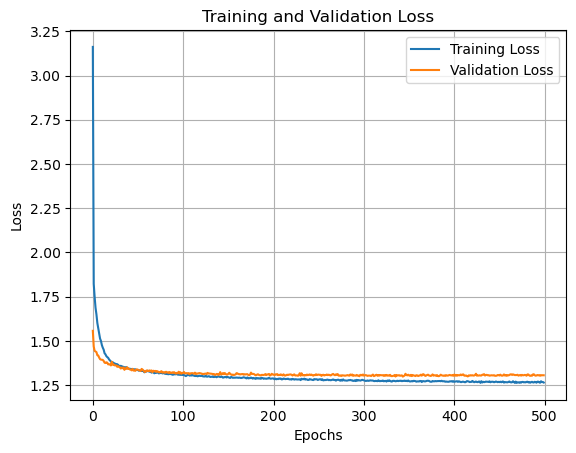

In [15]:
import matplotlib.pyplot as plt

# 2. Truy cập lịch sử từ thuộc tính .history_ của đối tượng model
train_loss = history.history_['loss']
val_loss = history.history_['val_loss']

# 3. Vẽ biểu đồ
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Lưu hình ảnh vào một file (ví dụ: 'loss_plot.png')
plt.savefig('neural_networks_1_loss_plot.png')

# Hiển thị biểu đồ
plt.show()


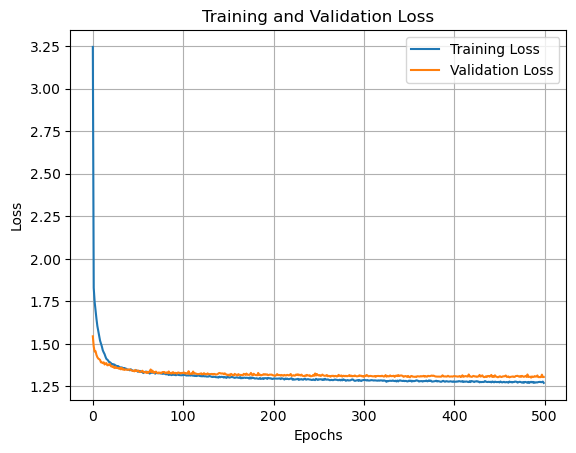

In [45]:
import matplotlib.pyplot as plt

# 2. Truy cập lịch sử từ thuộc tính .history_ của đối tượng model
train_loss = model.history_['loss']
val_loss = model.history_['val_loss']

# 3. Vẽ biểu đồ
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# ... sau khi chạy model.fit()

# KIỂM TRA DỮ LIỆU TRƯỚC KHI VẼ
print("Nội dung của history.history_:")
print(history.history_)

# --- Code vẽ biểu đồ của bạn ---
# train_mae = history.history_['mae']
# val_mae = history.history_['val_mae']
# ...

Nội dung của history.history_:
defaultdict(<class 'list'>, {'loss': [3.245504140853882, 1.8294224739074707, 1.7482235431671143, 1.6960670948028564, 1.648539423942566, 1.605653166770935, 1.575746774673462, 1.5476677417755127, 1.519250750541687, 1.501267671585083, 1.4850354194641113, 1.4628710746765137, 1.4506522417068481, 1.4401943683624268, 1.424909234046936, 1.4120339155197144, 1.4077330827713013, 1.4020079374313354, 1.3931995630264282, 1.3924131393432617, 1.3875715732574463, 1.3809140920639038, 1.3819829225540161, 1.3771767616271973, 1.3787322044372559, 1.3727813959121704, 1.3716458082199097, 1.3689810037612915, 1.3700543642044067, 1.365349292755127, 1.3626201152801514, 1.3583632707595825, 1.362080454826355, 1.3589274883270264, 1.3572276830673218, 1.3583496809005737, 1.353602409362793, 1.354431390762329, 1.3495079278945923, 1.3487902879714966, 1.3474401235580444, 1.3447794914245605, 1.351021647453308, 1.3466179370880127, 1.343960165977478, 1.3407306671142578, 1.3429276943206787, 1.34

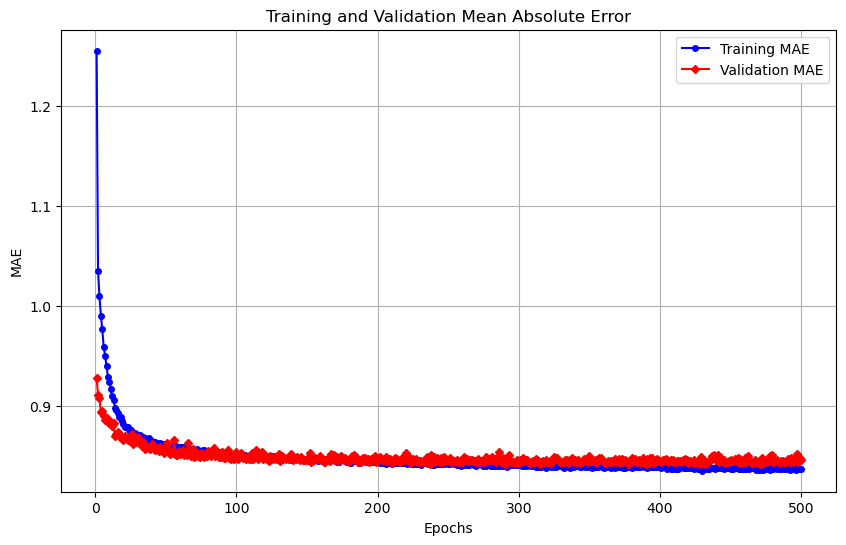

In [16]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history bằng ĐÚNG TÊN KEY
# THAY ĐỔI Ở ĐÂY: Dùng 'mean_absolute_error' thay vì 'mae'
train_mae = history.history_['mean_absolute_error']
val_mae = history.history_['val_mean_absolute_error']

# Tạo dãy số epochs
epochs = range(1, len(train_mae) + 1)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mae, 'bo-', label='Training MAE', markersize=4)
plt.plot(epochs, val_mae, 'rD-', label='Validation MAE', markersize=4)
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Lưu hình ảnh vào một file (ví dụ: 'mae_plot.png')
plt.savefig('NN1_mae_plot.png')

# Hiển thị biểu đồ
plt.show()


## Test model khác

In [18]:
# 1. Import các thư viện cần thiết, bao gồm KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor # <-- THAY ĐỔI QUAN TRỌNG
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 2. Định nghĩa hàm xây dựng mô hình (giữ nguyên như trước)
def build_model():
    model = Sequential([
        Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(units=64, activation='relu'),
        Dropout(0.2),
        Dense(units=32, activation='relu'),
        Dropout(0.3),
        Dense(units=1) # Lớp đầu ra cho hồi quy
    ])
    # Lưu ý: Không cần compile ở đây, SciKeras sẽ tự làm
    return model

# 3. Tạo một đối tượng KerasRegressor thay vì KerasClassifier
#    Đổi tên biến từ 'clf' thành 'model' hoặc 'regressor' cho rõ ràng
model = KerasRegressor(
    model=build_model,
    loss="mean_squared_error",
    optimizer="adam",
    optimizer__learning_rate=0.001,
    metrics=["mean_absolute_error"],
    verbose=1
)

# 4. Định nghĩa các callbacks (giữ nguyên)
es = EarlyStopping(monitor='val_loss', patience=50, verbose=True, mode='min')
mc = ModelCheckpoint('regression_model_best.keras', monitor='val_loss', save_best_only=True, mode='min')

# 5. Huấn luyện mô hình (bây giờ sẽ hoạt động)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    callbacks=[es, mc]
)

Epoch 1/500


C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2617/2617 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.4027 - mean_absolute_error: 1.8584 - val_loss: 1.6634 - val_mean_absolute_error: 0.9914
Epoch 2/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.4329 - mean_absolute_error: 1.2204 - val_loss: 1.5193 - val_mean_absolute_error: 0.9398
Epoch 3/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1.9911 - mean_absolute_error: 1.0966 - val_loss: 1.4808 - val_mean_absolute_error: 0.9260
Epoch 4/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.7841 - mean_absolute_error: 1.0332 - val_loss: 1.4429 - val_mean_absolute_error: 0.9058
Epoch 5/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.6624 - mean_absolute_error: 0.9834 - val_loss: 1.4104 - val_mean_absolute_error: 0.8837
Epoch 6/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.5407 - mean_absolute_error: 0.9436 - val_loss: 1.4003 - val_mean_absolute_error: 0.8849
Epoch 7/500
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.4918 - mean_absolute_err

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Lấy dự đoán từ mô hình (kết quả là số thực, không phải số nguyên)
y_pred = model.predict(X_test)

# 2. Tính toán các thước đo phù hợp cho hồi quy
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# 3. In kết quả ra màn hình
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Absolute Error (MAE): 0.8313
Mean Squared Error (MSE): 1.2564
Root Mean Squared Error (RMSE): 1.1209
R-squared (R²): 0.3085


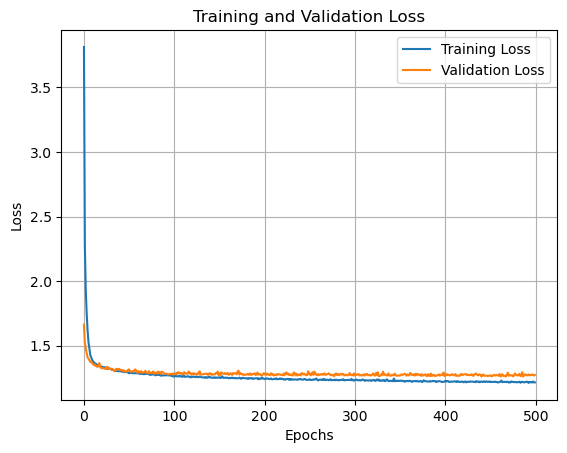

In [20]:
import matplotlib.pyplot as plt

# 2. Truy cập lịch sử từ thuộc tính .history_ của đối tượng model
train_loss = history.history_['loss']
val_loss = history.history_['val_loss']

# 3. Vẽ biểu đồ
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Lưu hình ảnh vào một file (ví dụ: 'loss_plot.png')
plt.savefig('neural_networks_2_loss_plot.png')

# Hiển thị biểu đồ
plt.show()


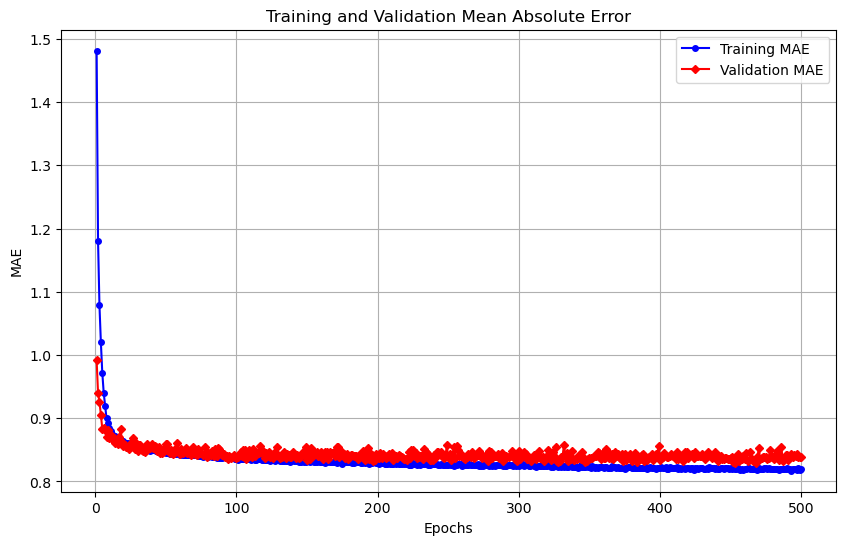

In [21]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history bằng ĐÚNG TÊN KEY
# THAY ĐỔI Ở ĐÂY: Dùng 'mean_absolute_error' thay vì 'mae'
train_mae = history.history_['mean_absolute_error']
val_mae = history.history_['val_mean_absolute_error']

# Tạo dãy số epochs
epochs = range(1, len(train_mae) + 1)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mae, 'bo-', label='Training MAE', markersize=4)
plt.plot(epochs, val_mae, 'rD-', label='Validation MAE', markersize=4)
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Lưu hình ảnh vào một file (ví dụ: 'mae_plot.png')
plt.savefig('NN2_mae_plot.png')

# Hiển thị biểu đồ
plt.show()


# NN1

In [21]:
def my_nn(hidden_layers, activation, lr, reg_type, reg_lambda, optimizer, momentum):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    for units in hidden_layers:
        model.add(layers.Dense(units=units,
                               activation=activation,
                               kernel_regularizer=reg_type(reg_lambda)))
    
    model.add(layers.Dense(units=1,
                           activation='linear',
                           kernel_regularizer=reg_type(reg_lambda)))

    if optimizer == 'adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        optimizer = optimizers.SGD(learning_rate=lr, momentum=momentum)
    
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    return model

In [23]:

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, verbose=True)
mc = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model = my_nn(hidden_layers=[128, 256, 128],
              activation='relu',
              lr=0.001,
              reg_type=regularizers.l1,
              reg_lambda=0.01,
              optimizer='adam',
              momentum=0.9)

history = model.fit(epochs=100,
                    x=X_train,
                    y=y_train,
                    shuffle=True,
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 59.4036 - mean_absolute_error: 3.4957 - val_loss: 29.4349 - val_mean_absolute_error: 1.3088
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 25.7885 - mean_absolute_error: 1.2261 - val_loss: 17.4199 - val_mean_absolute_error: 1.0749
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 15.7012 - mean_absolute_error: 1.0423 - val_loss: 11.5968 - val_mean_absolute_error: 1.0017
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.6047 - mean_absolute_error: 0.9873 - val_loss: 8.3526 - val_mean_absolute_error: 0.9707
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.7637 - mean_absolute_error: 0.9655 - val_loss: 6.3504 - val_mean_absolute_error: 0.9535
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0010 - mean_absolute_error: 0.9576 - val_loss: 5.0798 - val_mean_absolute_error: 0.9446
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.8353 - mean_absolute_error: 0.9467 - 

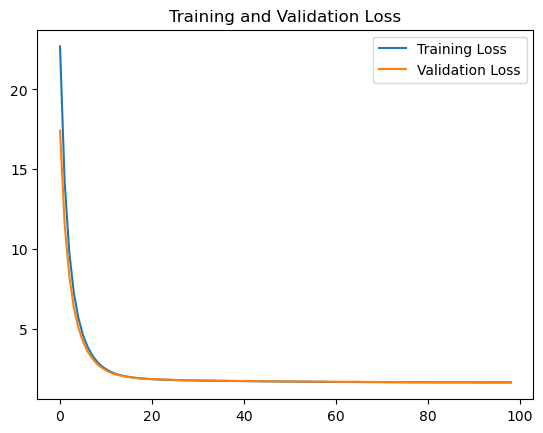

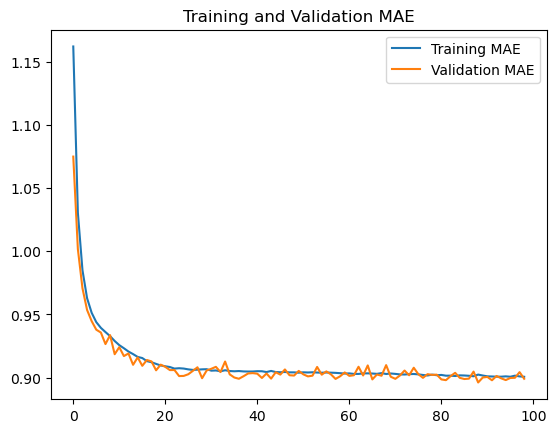

In [25]:
# Plot training and validation loss
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.savefig('./nn_mse_14_6.png', dpi=300, bbox_inches='tight')

plt.show()

# Plot training and validation MAE
plt.plot(history.history['mean_absolute_error'][1:], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'][1:], label='Validation MAE')
plt.legend()
plt.title('Training and Validation MAE')

plt.savefig('.nn_mae_14_6.png', dpi=300, bbox_inches='tight')

plt.show()

In [26]:

# Check test performance with r2_score, mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test)
print('R2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
R2 Score: 0.20135332693639219
Mean Squared Error: 1.4510498013948931
Mean Absolute Error: 0.8985891523352704


# NN2

In [29]:

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, verbose=True)
mc = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model = my_nn(hidden_layers=[2, 4, 4, 2],
              activation='relu',
              lr=0.01,
              reg_type=regularizers.l1,
              reg_lambda=0.005,
              optimizer='adam',
              momentum=0.9)

history = model.fit(epochs=500,
                    x=X_train,
                    y=y_train,
                    shuffle=True,
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 37.0877 - mean_absolute_error: 5.6766 - val_loss: 2.3679 - val_mean_absolute_error: 1.1433
Epoch 2/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9721 - mean_absolute_error: 1.0460 - val_loss: 1.8092 - val_mean_absolute_error: 0.9948
Epoch 3/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7781 - mean_absolute_error: 0.9881 - val_loss: 1.7734 - val_mean_absolute_error: 0.9807
Epoch 4/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7543 - mean_absolute_error: 0.9778 - val_loss: 1.7472 - val_mean_absolute_error: 0.9737
Epoch 5/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7422 - mean_absolute_error: 0.9742 - val_loss: 1.7330 - val_mean_absolute_error: 0.9714
Epoch 6/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7115 - mean_absolute_error: 0.9665 - val_loss: 1.7177 - val_mean_absolute_error: 0.9628
Epoch 7/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7161 - mean_absolute_error: 0.9671 - val_los

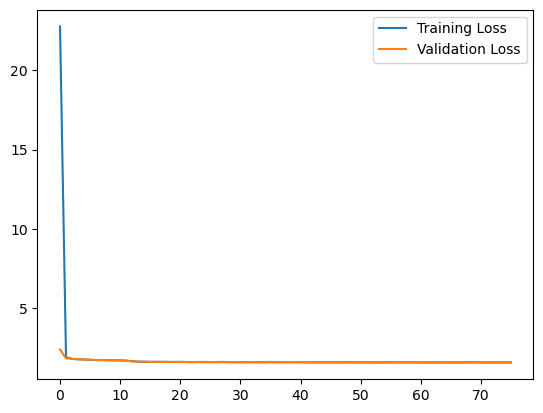

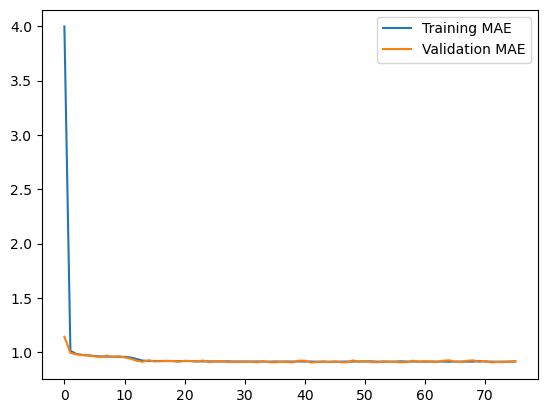

In [30]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.show()

In [32]:

# Check test performance with r2_score, mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test)
print('R2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
R2 Score: 0.18126615434841709
Mean Squared Error: 1.48754590007963
Mean Absolute Error: 0.9198068104617254


# NN3

In [34]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, verbose=True)
mc = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model = my_nn(hidden_layers=[16, 32],
              activation='relu',
              lr=0.01,
              reg_type=regularizers.l1,
              reg_lambda=0.1,
              optimizer='adam',
              momentum=0.9)

history = model.fit(epochs=1000,
                    x=X_train,
                    y=y_train,
                    shuffle=True,
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 29.8425 - mean_absolute_error: 3.1881 - val_loss: 6.6130 - val_mean_absolute_error: 1.0610
Epoch 2/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4515 - mean_absolute_error: 1.0198 - val_loss: 3.5601 - val_mean_absolute_error: 0.9986
Epoch 3/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3569 - mean_absolute_error: 0.9990 - val_loss: 2.9605 - val_mean_absolute_error: 1.0014
Epoch 4/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8851 - mean_absolute_error: 0.9957 - val_loss: 2.7175 - val_mean_absolute_error: 0.9840
Epoch 5/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6494 - mean_absolute_error: 0.9865 - val_loss: 2.4921 - val_mean_absolute_error: 0.9803
Epoch 6/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4489 - mean_absolute_error: 0.9790 - val_loss: 2.3472 - val_mean_absolute_error: 0.9790
Epoch 7/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3261 - mean_absolute_error: 0.9789 - 

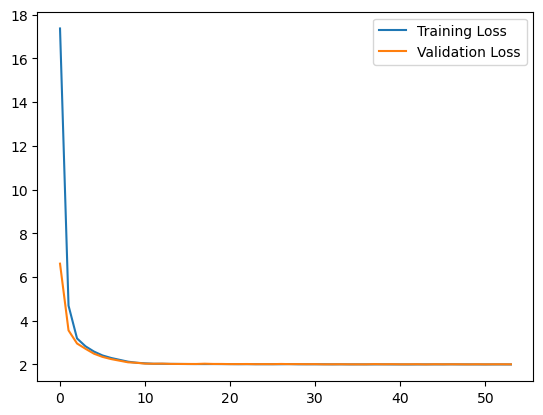

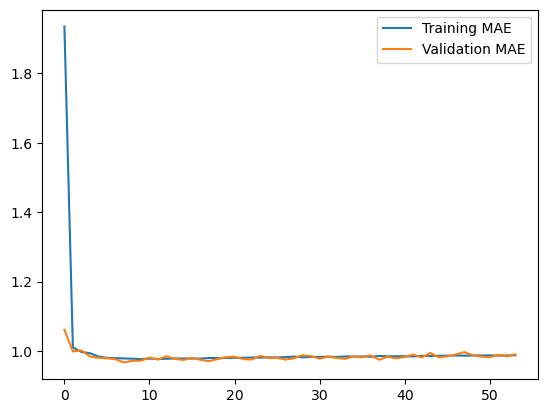

In [35]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.show()

In [37]:

# Check test performance with r2_score, mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test)
print('R2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
R2 Score: 0.0846307917658754
Mean Squared Error: 1.6631213183621933
Mean Absolute Error: 0.9895449704226775


# NN4

In [38]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, verbose=True)
mc = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model = my_nn(hidden_layers=[128, 64],
              activation='relu',
              lr=0.01,
              reg_type=regularizers.l1,
              reg_lambda=0.1,
              optimizer='adam',
              momentum=0.9)

history = model.fit(epochs=1000,
                    x=X_train,
                    y=y_train,
                    shuffle=True,
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 54.8495 - mean_absolute_error: 2.2258 - val_loss: 5.1041 - val_mean_absolute_error: 1.0394
Epoch 2/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6466 - mean_absolute_error: 1.0309 - val_loss: 4.1512 - val_mean_absolute_error: 1.0028
Epoch 3/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0584 - mean_absolute_error: 0.9865 - val_loss: 3.8539 - val_mean_absolute_error: 0.9906
Epoch 4/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8034 - mean_absolute_error: 0.9872 - val_loss: 3.6513 - val_mean_absolute_error: 0.9784
Epoch 5/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6145 - mean_absolute_error: 0.9820 - val_loss: 3.4784 - val_mean_absolute_error: 0.9888
Epoch 6/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4690 - mean_absolute_error: 0.9837 - val_loss: 3.4056 - val_mean_absolute_error: 0.9790
Epoch 7/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3404 - mean_absolute_error: 0.9849 - 

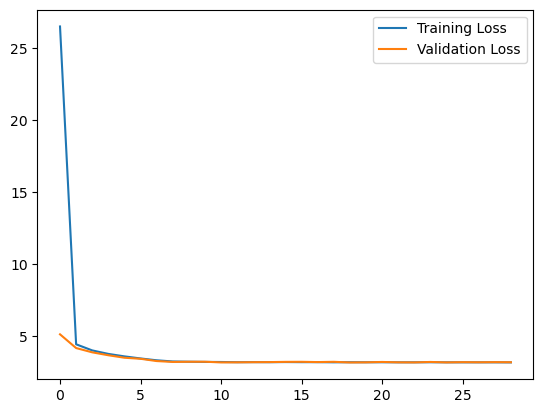

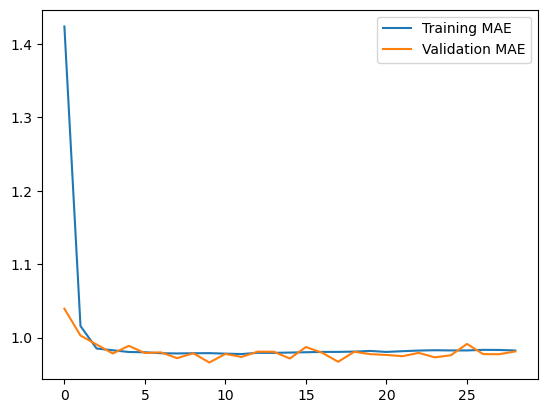

In [39]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.show()

In [40]:

# Check test performance with r2_score, mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test)
print('R2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
R2 Score: 0.0910940960346236
Mean Squared Error: 1.651378232599943
Mean Absolute Error: 0.9798382370970476


# Grid search

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from keras import models, layers, optimizers
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Hàm để xây dựng mô hình neural network
def my_nn(hidden_layers, activation, lr, reg_type, reg_lambda, optimizer, momentum):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    for units in hidden_layers:
        model.add(layers.Dense(units=units,
                               activation=activation,
                               kernel_regularizer=reg_type(reg_lambda)))
    
    model.add(layers.Dense(units=1,
                           activation='linear',
                           kernel_regularizer=reg_type(reg_lambda)))

    if optimizer == 'adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        optimizer = optimizers.SGD(learning_rate=lr, momentum=momentum)
    
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    return model

# Chuyển mô hình Keras thành mô hình sklearn (KerasRegressor)
model = KerasRegressor(model=my_nn, verbose=0)

# Thiết lập các tham số cho GridSearchCV
param_grid = {
    'hidden_layers': [[64, 32], [128, 64], [64, 64, 32]],  # Các cấu trúc lớp ẩn khác nhau
    'activation': ['relu', 'tanh'],  # Các hàm kích hoạt
    'lr': [0.001, 0.01, 0.1],  # Các giá trị learning rate khác nhau
    'reg_type': ['l2', 'l1'],  # Các loại regularization (L1, L2)
    'reg_lambda': [0.001, 0.01, 0.1],  # Các giá trị regularization lambda
    'optimizer': ['adam', 'sgd'],  # Các loại optimizer
    'momentum': [0.5, 0.9],  # Chỉ áp dụng cho 'sgd'
}

# Tạo custom scorer (sử dụng MSE hoặc R2 score)
mse_scorer = make_scorer(mean_squared_error)

# Khởi tạo GridSearchCV với custom scoring
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1, scoring=mse_scorer)

# Tiến hành tìm kiếm Grid Search
grid_search.fit(X_train, y_train)

# In kết quả của grid search
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Đánh giá mô hình trên tập kiểm tra
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test score: {test_score}")


AttributeError: 'super' object has no attribute '__sklearn_tags__'

## k chạy dc

# Random forrest

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
# 5. **Random Forest Regressor**
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)  # n_estimators là số lượng cây quyết định
# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on both training and test data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate on training data
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Evaluate on test data
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print("\nRandom Forest Regressor:")

# Train performance
print(f"Training R2 Score: {train_r2}")
print(f"Training Mean Squared Error: {train_mse}")
print(f"Training Mean Absolute Error: {train_mae}")

# Test performance
print(f"Test R2 Score: {test_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")

KeyboardInterrupt: 

In [60]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Số lượng cây quyết định
    'max_depth': [None, 10, 20, 30],  # Độ sâu tối đa của mỗi cây
    'min_samples_split': [2, 5, 10],  # Số lượng mẫu tối thiểu để chia một nút
    'min_samples_leaf': [1, 2, 4],  # Số lượng mẫu tối thiểu ở mỗi lá
    'max_features': ['auto', 'sqrt', 'log2'],  # Số lượng đặc trưng tối đa để chia
}

from sklearn.model_selection import RandomizedSearchCV

# Khởi tạo RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Tiến hành tìm kiếm ngẫu nhiên
random_search.fit(X_train, y_train)

# In kết quả của random search
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score (Negative MSE): {random_search.best_score_}")

# Đánh giá mô hình trên tập kiểm tra
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Tính toán R², MSE, và MAE trên tập kiểm tra
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test R2 Score: {r2}")
print(f"Test Mean Squared Error: {mse}")
print(f"Test Mean Absolute Error: {mae}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
105 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 436, in _validate_params
    valid

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}
Best score (Negative MSE): -1.095665698881846


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 2, max_features = 'log2', max_depth =30, random_state=42)  # n_estimators là số lượng cây quyết định
rf.fit(X_train, y_train)

# Predict on both training and test data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate on training data
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Evaluate on test data
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print("\nRandom Forest Regressor:")

# Train performance
print(f"Training R2 Score: {train_r2}")
print(f"Training Mean Squared Error: {train_mse}")
print(f"Training Mean Absolute Error: {train_mae}")

# Test performance
print(f"Test R2 Score: {test_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")


Random Forest Regressor:
Training R2 Score: 0.7587652538766854
Training Mean Squared Error: 0.4386862880316007
Training Mean Absolute Error: 0.4693469682893642
Test R2 Score: 0.40557398513338927
Test Mean Squared Error: 1.0800041869672405
Test Mean Absolute Error: 0.7544015062609777


## Test lại bỏ max depth

In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],  # Số lượng cây quyết định
    'min_samples_split': [2, 5, 10],  # Số lượng mẫu tối thiểu để chia một nút
    'min_samples_leaf': [1, 2, 4],  # Số lượng mẫu tối thiểu ở mỗi lá
    'max_features': ['auto', 'sqrt', 'log2'],  # Số lượng đặc trưng tối đa để chia
}

from sklearn.model_selection import RandomizedSearchCV

# Khởi tạo RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Tiến hành tìm kiếm ngẫu nhiên
random_search.fit(X_train, y_train)

# In kết quả của random search
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score (Negative MSE): {random_search.best_score_}")



Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
95 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 436, in _validate_params
    valida

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best score (Negative MSE): -1.0778145917459476


NameError: name 'grid_search' is not defined

In [15]:
# Đánh giá mô hình trên tập kiểm tra
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Tính toán R², MSE, và MAE trên tập kiểm tra
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test R2 Score: {r2}")
print(f"Test Mean Squared Error: {mse}")
print(f"Test Mean Absolute Error: {mae}")

Test R2 Score: 0.4159531927758555
Test Mean Squared Error: 1.0611463519618507
Test Mean Absolute Error: 0.7453544846790713


In [16]:
best_model.fit(X_train, y_train)

# Predict on both training and test data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluate on training data
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Evaluate on test data
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print("\nRandom Forest Regressor:")

# Train performance
print(f"Training R2 Score: {train_r2}")
print(f"Training Mean Squared Error: {train_mse}")
print(f"Training Mean Absolute Error: {train_mae}")

# Test performance
print(f"Test R2 Score: {test_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")


Random Forest Regressor:
Training R2 Score: 0.8849941769452172
Training Mean Squared Error: 0.20913851934137176
Training Mean Absolute Error: 0.32982848373223456
Test R2 Score: 0.4159531927758555
Test Mean Squared Error: 1.0611463519618507
Test Mean Absolute Error: 0.7453544846790713


## Do gặp overfitting nên thêm maxdepth 12 vào

In [17]:
# After obtaining the best model from random search
best_model = random_search.best_estimator_

# Set the max_depth to 12
best_model.set_params(max_depth=12)

# Predict on the test data
y_pred = best_model.predict(X_test)

In [18]:
best_model.fit(X_train, y_train)

# Predict on both training and test data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluate on training data
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Evaluate on test data
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print("\nRandom Forest Regressor:")

# Train performance
print(f"Training R2 Score: {train_r2}")
print(f"Training Mean Squared Error: {train_mse}")
print(f"Training Mean Absolute Error: {train_mae}")

# Test performance
print(f"Test R2 Score: {test_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")


Random Forest Regressor:
Training R2 Score: 0.37691696452294343
Training Mean Squared Error: 1.1330788303156247
Training Mean Absolute Error: 0.789495394490855
Test R2 Score: 0.3087848788413242
Test Mean Squared Error: 1.2558589400128397
Test Mean Absolute Error: 0.8294829996183336


## Final random search for random foresst with max depth from 9 to 12

In [13]:
# Giả sử các thư viện cần thiết đã được import
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# và các biến X_train, y_train, X_test, y_test đã tồn tại

# 1. Khởi tạo mô hình cơ sở để tinh chỉnh
# Đây là estimator sẽ được RandomizedSearchCV sử dụng
rf_base = RandomForestRegressor(random_state=42)

# 2. Định nghĩa không gian tham số để tìm kiếm
param_grid = {
    'n_estimators': [50, 100, 200],          # Số lượng cây quyết định
    'max_depth': [9, 10, 11, 12],      # Độ sâu tối đa của mỗi cây
    'min_samples_split': [2, 5, 10],         # Số lượng mẫu tối thiểu để chia một nút
    'min_samples_leaf': [1, 2, 4],           # Số lượng mẫu tối thiểu ở mỗi lá
    'max_features': ['sqrt', 'log2'],        # Số lượng đặc trưng tối đa để chia ('auto' tương đương 'sqrt' trong các phiên bản mới)
}

# 3. Thiết lập và chạy RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=50,                           # Số lượng kết hợp tham số để thử
    cv=5,                                # Số fold cho cross-validation
    scoring='neg_mean_squared_error',    # Thước đo để tối ưu
    verbose=1,
    n_jobs=-1,                           # Sử dụng tất cả các CPU có sẵn
    random_state=42                      # Để kết quả có thể được tái tạo
)

# Tiến hành tìm kiếm trên dữ liệu huấn luyện
random_search.fit(X_train, y_train)

# 4. In ra kết quả tìm kiếm tốt nhất
print("--- Kết quả từ RandomizedSearch ---")
print(f"Tham số tốt nhất tìm được: {random_search.best_params_}")
print(f"Điểm số tốt nhất (Negative MSE): {random_search.best_score_}")
print("-" * 35 + "\n")

# 5. Lấy ra mô hình tốt nhất và đánh giá hiệu năng
best_model = random_search.best_estimator_

# Dự đoán trên cả tập huấn luyện và tập kiểm tra
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# 6. Tính toán và in các chỉ số đánh giá
print("--- Đánh giá hiệu năng của mô hình tốt nhất ---")

# Đánh giá trên tập huấn luyện
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
print("Hiệu năng trên tập huấn luyện (Train):")
print(f"  R2 Score: {train_r2:.4f}")
print(f"  Mean Squared Error (MSE): {train_mse:.4f}")
print(f"  Mean Absolute Error (MAE): {train_mae:.4f}\n")

# Đánh giá trên tập kiểm tra
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Hiệu năng trên tập kiểm tra (Test):")
print(f"  R2 Score: {test_r2:.4f}")
print(f"  Mean Squared Error (MSE): {test_mse:.4f}")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--- Kết quả từ RandomizedSearch ---
Tham số tốt nhất tìm được: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 12}
Điểm số tốt nhất (Negative MSE): -1.2592018271852279
-----------------------------------

--- Đánh giá hiệu năng của mô hình tốt nhất ---
Hiệu năng trên tập huấn luyện (Train):
  R2 Score: 0.3696
  Mean Squared Error (MSE): 1.1463
  Mean Absolute Error (MAE): 0.7924

Hiệu năng trên tập kiểm tra (Test):
  R2 Score: 0.3089
  Mean Squared Error (MSE): 1.2557
  Mean Absolute Error (MAE): 0.8293


In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# 1. Định nghĩa bộ tham số tối ưu đã tìm được
# Đây là bộ tham số bạn đã cung cấp
best_params = {
    'n_estimators': 200,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 12
}

# 2. Khởi tạo mô hình Random Forest với các tham số tốt nhất
# Thêm random_state=42 để đảm bảo kết quả có thể tái tạo
final_rf_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)

# 3. Huấn luyện (fit) mô hình trên toàn bộ tập dữ liệu huấn luyện
print("--- Bắt đầu huấn luyện mô hình với tham số tối ưu ---")
final_rf_model.fit(X_train, y_train)
print("--- Hoàn tất huấn luyện --- \n")

# 4. Thực hiện dự đoán trên tập kiểm tra (test set)
y_pred = final_rf_model.predict(X_test)

# 5. Đánh giá hiệu năng của mô hình trên tập kiểm tra
print("--- Đánh giá hiệu năng của mô hình cuối cùng trên tập Test ---")

# Tính toán các chỉ số đánh giá
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse) # Thêm RMSE để dễ diễn giải
test_mae = mean_absolute_error(y_test, y_pred)

# In kết quả
print(f"  R2 Score: {test_r2:.4f}")
print(f"  Mean Squared Error (MSE): {test_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")

--- Bắt đầu huấn luyện mô hình với tham số tối ưu ---
--- Hoàn tất huấn luyện --- 

--- Đánh giá hiệu năng của mô hình cuối cùng trên tập Test ---
  R2 Score: 0.3089
  Mean Squared Error (MSE): 1.2557
  Root Mean Squared Error (RMSE): 1.1206
  Mean Absolute Error (MAE): 0.8293



--- Biểu đồ đã được lưu thành công tại: C:\Users\manht\Data Mining sem 2\feature_importance.png ---


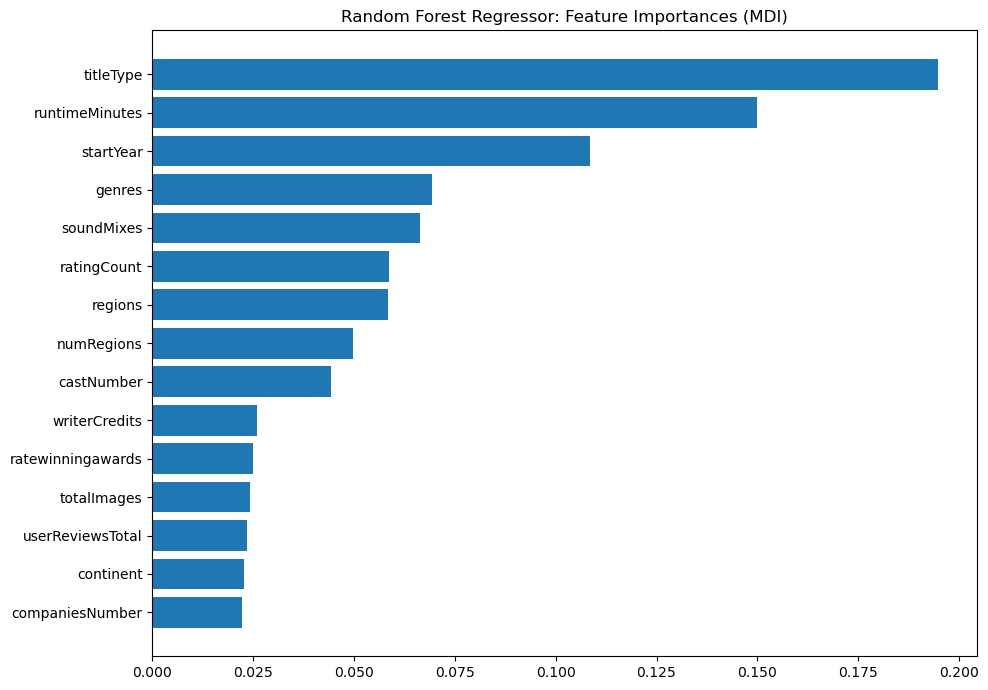

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Giả định ---
# final_rf_model: là mô hình RandomForestRegressor đã được huấn luyện.
# X: là Pandas DataFrame chứa các đặc trưng (ví dụ: X_train).
# -----------------

# 1. Đặt số lượng đặc trưng quan trọng nhất muốn hiển thị
nbr_features = 15

# 2. Lấy ra mức độ quan trọng và sắp xếp các chỉ số của top N đặc trưng
feature_importances = final_rf_model.feature_importances_
sorted_idx = feature_importances.argsort()[-nbr_features:]

# 3. Tạo vị trí cho các thanh trên trục y
y_ticks = np.arange(0, len(sorted_idx))

# 4. Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(y_ticks, feature_importances[sorted_idx])

# 5. Gán tên đặc trưng tương ứng lên các thanh
ax.set_yticks(y_ticks)
ax.set_yticklabels(X.columns[sorted_idx])

save_path = r"C:\Users\manht\Data Mining sem 2\feature_importance.png"

try:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n--- Biểu đồ đã được lưu thành công tại: {save_path} ---")
except Exception as e:
    print(f"\n--- Đã xảy ra lỗi khi lưu file: {e} ---")
# 6. Đặt tiêu đề và hiển thị
ax.set_title("Random Forest Regressor: Feature Importances (MDI)")
plt.tight_layout()
plt.show()




--- Bắt đầu tính toán Permutation Importance ---
--- Hoàn tất tính toán --- 



C:\Users\manht\AppData\Local\Temp\ipykernel_6852\160709595.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,



--- Biểu đồ đã được lưu thành công tại: C:\Users\manht\Data Mining sem 2\permutation_importance.png ---


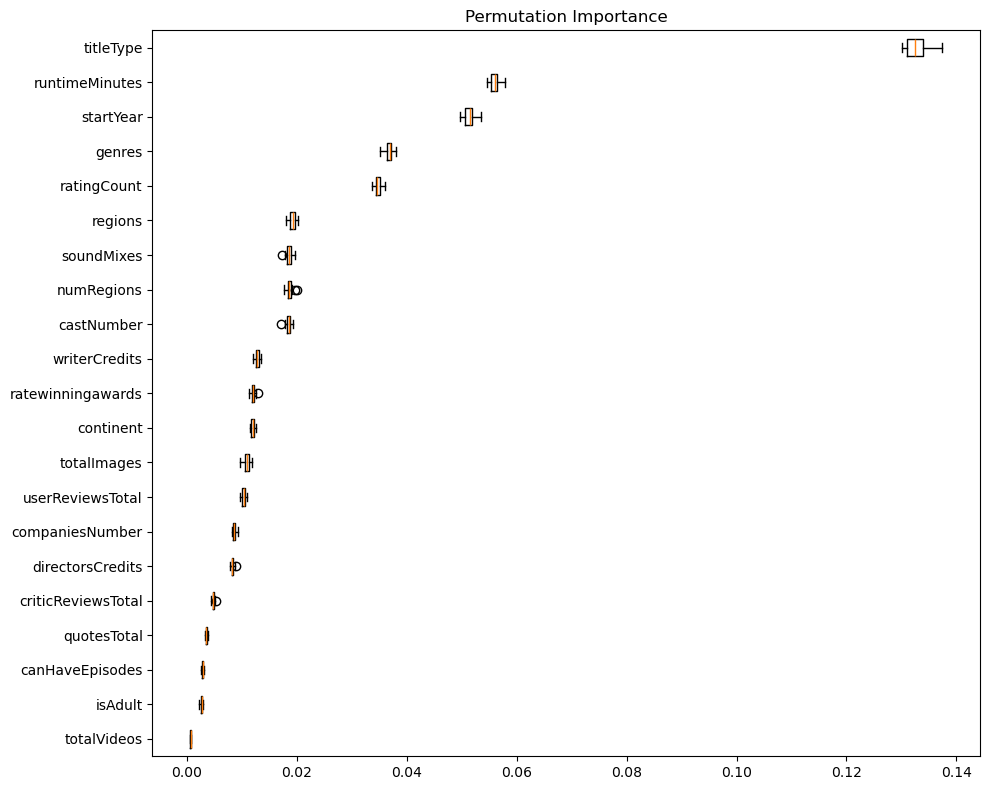

In [42]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# --- 6. Tính toán và vẽ biểu đồ Permutation Importance trên tập Test ---
print("--- Bắt đầu tính toán Permutation Importance ---")

# Tính toán importance
# n_repeats là số lần hoán vị cho mỗi đặc trưng để có kết quả ổn định
# random_state để đảm bảo kết quả có thể tái tạo
result = permutation_importance(
    final_rf_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1
)

print("--- Hoàn tất tính toán --- \n")

# Sắp xếp các đặc trưng theo mức độ quan trọng trung bình
sorted_idx = result.importances_mean.argsort()

# Lấy tên các đặc trưng theo thứ tự đã sắp xếp
# Giả định X_train là một DataFrame của pandas để có thể lấy tên cột
feature_names = np.array(X.columns)

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(10, 8)) # Tăng kích thước để dễ nhìn hơn

# Sử dụng boxplot để thể hiện sự phân bổ của importance scores
ax.boxplot(result.importances[sorted_idx].T,
           vert=False,
           labels=feature_names[sorted_idx])


save_path = r"C:\Users\manht\Data Mining sem 2\permutation_importance.png"

try:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n--- Biểu đồ đã được lưu thành công tại: {save_path} ---")
except Exception as e:
    print(f"\n--- Đã xảy ra lỗi khi lưu file: {e} ---")

ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

In [41]:
# 1. Định nghĩa đường dẫn và tên file bạn muốn lưu
# Quan trọng: Chữ 'r' đứng trước chuỗi ("raw string") để Python 
# xử lý đúng các dấu gạch chéo ngược '\' trong đường dẫn của Windows.
save_path = r"C:\Users\manht\Data Mining sem 2\permutation_importance.png"

# 2. Sử dụng plt.savefig() để lưu file
# - dpi=300: tăng độ phân giải cho ảnh sắc nét hơn.
# - bbox_inches='tight': đảm bảo toàn bộ biểu đồ (kể cả nhãn) được lưu.
try:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n--- Biểu đồ đã được lưu thành công tại: {save_path} ---")
except Exception as e:
    print(f"\n--- Đã xảy ra lỗi khi lưu file: {e} ---")


--- Biểu đồ đã được lưu thành công tại: C:\Users\manht\Data Mining sem 2\permutation_importance.png ---


<Figure size 640x480 with 0 Axes>

# Gradient boosting

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model on the training data
gbr.fit(X_train, y_train)

# Predict on both training and test data
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

# Evaluate on training data
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Evaluate on test data
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print("\nGradient Boosting Regressor:")

# Train performance
print(f"Training R2 Score: {train_r2}")
print(f"Training Mean Squared Error: {train_mse}")
print(f"Training Mean Absolute Error: {train_mae}")

# Test performance
print(f"Test R2 Score: {test_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")


Gradient Boosting Regressor:
Training R2 Score: 0.276354980953881
Training Mean Squared Error: 1.3159511735329488
Training Mean Absolute Error: 0.8505545439900845
Test R2 Score: 0.2703197344475802
Test Mean Squared Error: 1.325745714747733
Test Mean Absolute Error: 0.8534739053489806


In [20]:
# Khởi tạo mô hình Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Thiết lập các tham số cho RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],  # Số lượng cây quyết định trong mô hình boosting
    'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Tỷ lệ học
    'max_depth': [3, 5, 7, 10],  # Độ sâu tối đa của mỗi cây
    'subsample': [0.8, 0.9, 1.0],  # Tỷ lệ mẫu ngẫu nhiên trong mỗi cây
    'min_samples_split': [2, 5, 10, 20],  # Số lượng mẫu tối thiểu để chia một nút
}

# Khởi tạo RandomizedSearchCV để tìm kiếm tham số tối ưu
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_dist, 
                                   n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, 
                                   n_jobs=-1, random_state=42)

# Tiến hành tìm kiếm Randomized Search
random_search.fit(X_train, y_train)

# In kết quả của random search
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score (Negative MSE): {random_search.best_score_}")

# Đánh giá mô hình trên tập kiểm tra
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Tính toán R², MSE, và MAE trên tập kiểm tra
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test R2 Score: {r2}")
print(f"Test Mean Squared Error: {mse}")
print(f"Test Mean Absolute Error: {mae}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 20, 'max_depth': 10, 'learning_rate': 0.1}
Best score (Negative MSE): -1.120671577491798
Test R2 Score: 0.3909639110796197
Test Mean Squared Error: 1.106549023087028
Test Mean Absolute Error: 0.7666644030086186


In [22]:
best_model.fit(X_train, y_train)

# Predict on both training and test data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluate on training data
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Evaluate on test data
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print("\nGradient boosting Regressor:")

# Train performance
print(f"Training R2 Score: {train_r2}")
print(f"Training Mean Squared Error: {train_mse}")
print(f"Training Mean Absolute Error: {train_mae}")

# Test performance
print(f"Test R2 Score: {test_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")


Gradient boosting Regressor:
Training R2 Score: 0.5738450269884414
Training Mean Squared Error: 0.7749644122206306
Training Mean Absolute Error: 0.6448229240945865
Test R2 Score: 0.3909639110796197
Test Mean Squared Error: 1.106549023087028
Test Mean Absolute Error: 0.7666644030086186


### Test để giảm overfitting

In [23]:
handle_overfitting_1 = GradientBoostingRegressor(
    subsample=0.8,
    n_estimators=100,
    min_samples_split=20,
    max_depth=10,
    learning_rate=0.1
)

# Huấn luyện mô hình trên dữ liệu huấn luyện
handle_overfitting_1.fit(X_train, y_train)

# Dự đoán trên cả dữ liệu huấn luyện và kiểm tra
y_train_pred = handle_overfitting_1.predict(X_train)
y_test_pred = handle_overfitting_1.predict(X_test)

# Đánh giá trên dữ liệu huấn luyện
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Đánh giá trên dữ liệu kiểm tra
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# In kết quả
print("\nGradient Boosting Regressor:")

# Đánh giá hiệu suất trên dữ liệu huấn luyện
print(f"Training R2 Score: {train_r2}")
print(f"Training Mean Squared Error: {train_mse}")
print(f"Training Mean Absolute Error: {train_mae}")

# Đánh giá hiệu suất trên dữ liệu kiểm tra
print(f"Test R2 Score: {test_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")



Gradient Boosting Regressor:
Training R2 Score: 0.5705032101666203
Training Mean Squared Error: 0.7810415186093467
Training Mean Absolute Error: 0.6471514766900552
Test R2 Score: 0.39000218186027036
Test Mean Squared Error: 1.108296375251383
Test Mean Absolute Error: 0.768178151785335


### Tốt hơn cả random search? nhưng vẫn ovewrfitting => thử giảm max depth

In [24]:
handle_overfitting_1 = GradientBoostingRegressor(
    subsample=0.8,
    n_estimators=100,
    min_samples_split=20,
    max_depth=5,
    learning_rate=0.1
)

# Huấn luyện mô hình trên dữ liệu huấn luyện
handle_overfitting_1.fit(X_train, y_train)

# Dự đoán trên cả dữ liệu huấn luyện và kiểm tra
y_train_pred = handle_overfitting_1.predict(X_train)
y_test_pred = handle_overfitting_1.predict(X_test)

# Đánh giá trên dữ liệu huấn luyện
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Đánh giá trên dữ liệu kiểm tra
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# In kết quả
print("\nGradient Boosting Regressor:")

# Đánh giá hiệu suất trên dữ liệu huấn luyện
print(f"Training R2 Score: {train_r2}")
print(f"Training Mean Squared Error: {train_mse}")
print(f"Training Mean Absolute Error: {train_mae}")

# Đánh giá hiệu suất trên dữ liệu kiểm tra
print(f"Test R2 Score: {test_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")



Gradient Boosting Regressor:
Training R2 Score: 0.3407512570673815
Training Mean Squared Error: 1.1988463045815714
Training Mean Absolute Error: 0.8083385716100573
Test R2 Score: 0.31873933342973904
Test Mean Squared Error: 1.237772832800867
Test Mean Absolute Error: 0.8204006508468237


In [25]:
handle_overfitting_1 = GradientBoostingRegressor(
    subsample=0.8,
    n_estimators=100,
    min_samples_split=20,
    max_depth=8,
    learning_rate=0.1
)

# Huấn luyện mô hình trên dữ liệu huấn luyện
handle_overfitting_1.fit(X_train, y_train)

# Dự đoán trên cả dữ liệu huấn luyện và kiểm tra
y_train_pred = handle_overfitting_1.predict(X_train)
y_test_pred = handle_overfitting_1.predict(X_test)

# Đánh giá trên dữ liệu huấn luyện
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Đánh giá trên dữ liệu kiểm tra
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# In kết quả
print("\nGradient Boosting Regressor:")

# Đánh giá hiệu suất trên dữ liệu huấn luyện
print(f"Training R2 Score: {train_r2}")
print(f"Training Mean Squared Error: {train_mse}")
print(f"Training Mean Absolute Error: {train_mae}")

# Đánh giá hiệu suất trên dữ liệu kiểm tra
print(f"Test R2 Score: {test_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")



Gradient Boosting Regressor:
Training R2 Score: 0.46479987827361413
Training Mean Squared Error: 0.9732634229821578
Training Mean Absolute Error: 0.725652020537826
Test R2 Score: 0.36923245923192993
Test Mean Squared Error: 1.146032589413863
Test Mean Absolute Error: 0.7848357165555043


## Final test với max depth 3 4 5 

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
# Khởi tạo mô hình Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Thiết lập các tham số cho RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],  # Số lượng cây quyết định trong mô hình boosting
    'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Tỷ lệ học
    'max_depth': [3, 4, 5],  # Độ sâu tối đa của mỗi cây
    'subsample': [0.8, 0.9, 1.0],  # Tỷ lệ mẫu ngẫu nhiên trong mỗi cây
    'min_samples_split': [2, 5, 10, 20],  # Số lượng mẫu tối thiểu để chia một nút
}

# Khởi tạo RandomizedSearchCV để tìm kiếm tham số tối ưu
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_dist, 
                                   n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, 
                                   n_jobs=-1, random_state=42)

# Tiến hành tìm kiếm trên dữ liệu huấn luyện
random_search.fit(X_train, y_train)

# 4. In ra kết quả tìm kiếm tốt nhất
print("--- Kết quả từ RandomizedSearch ---")
print(f"Tham số tốt nhất tìm được: {random_search.best_params_}")
print(f"Điểm số tốt nhất (Negative MSE): {random_search.best_score_}")
print("-" * 35 + "\n")

# 5. Lấy ra mô hình tốt nhất và đánh giá hiệu năng
best_model = random_search.best_estimator_

# Dự đoán trên cả tập huấn luyện và tập kiểm tra
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# 6. Tính toán và in các chỉ số đánh giá
print("--- Đánh giá hiệu năng của mô hình tốt nhất ---")

# Đánh giá trên tập huấn luyện
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
print("Hiệu năng trên tập huấn luyện (Train):")
print(f"  R2 Score: {train_r2:.4f}")
print(f"  Mean Squared Error (MSE): {train_mse:.4f}")
print(f"  Mean Absolute Error (MAE): {train_mae:.4f}\n")

# Đánh giá trên tập kiểm tra
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Hiệu năng trên tập kiểm tra (Test):")
print(f"  R2 Score: {test_r2:.4f}")
print(f"  Mean Squared Error (MSE): {test_mse:.4f}")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--- Kết quả từ RandomizedSearch ---
Tham số tốt nhất tìm được: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 5, 'max_depth': 5, 'learning_rate': 0.2}
Điểm số tốt nhất (Negative MSE): -1.1612302772323333
-----------------------------------

--- Đánh giá hiệu năng của mô hình tốt nhất ---
Hiệu năng trên tập huấn luyện (Train):
  R2 Score: 0.4497
  Mean Squared Error (MSE): 1.0007
  Mean Absolute Error (MAE): 0.7340

Hiệu năng trên tập kiểm tra (Test):
  R2 Score: 0.3651
  Mean Squared Error (MSE): 1.1535
  Mean Absolute Error (MAE): 0.7877


In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
# Khởi tạo mô hình Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Thiết lập các tham số cho RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],  # Số lượng cây quyết định trong mô hình boosting
    'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Tỷ lệ học
    'max_depth': [3, 4, 5],  # Độ sâu tối đa của mỗi cây
}

# Khởi tạo RandomizedSearchCV để tìm kiếm tham số tối ưu
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_dist, 
                                   n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, 
                                   n_jobs=-1, random_state=42)

# Tiến hành tìm kiếm trên dữ liệu huấn luyện
random_search.fit(X_train, y_train)

# 4. In ra kết quả tìm kiếm tốt nhất
print("--- Kết quả từ RandomizedSearch ---")
print(f"Tham số tốt nhất tìm được: {random_search.best_params_}")
print(f"Điểm số tốt nhất (Negative MSE): {random_search.best_score_}")
print("-" * 35 + "\n")

# 5. Lấy ra mô hình tốt nhất và đánh giá hiệu năng
best_model = random_search.best_estimator_

# Dự đoán trên cả tập huấn luyện và tập kiểm tra
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# 6. Tính toán và in các chỉ số đánh giá
print("--- Đánh giá hiệu năng của mô hình tốt nhất ---")

# Đánh giá trên tập huấn luyện
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
print("Hiệu năng trên tập huấn luyện (Train):")
print(f"  R2 Score: {train_r2:.4f}")
print(f"  Mean Squared Error (MSE): {train_mse:.4f}")
print(f"  Mean Absolute Error (MAE): {train_mae:.4f}\n")

# Đánh giá trên tập kiểm tra
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Hiệu năng trên tập kiểm tra (Test):")
print(f"  R2 Score: {test_r2:.4f}")
print(f"  Mean Squared Error (MSE): {test_mse:.4f}")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--- Kết quả từ RandomizedSearch ---
Tham số tốt nhất tìm được: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2}
Điểm số tốt nhất (Negative MSE): -1.1614367953010576
-----------------------------------

--- Đánh giá hiệu năng của mô hình tốt nhất ---
Hiệu năng trên tập huấn luyện (Train):
  R2 Score: 0.4516
  Mean Squared Error (MSE): 0.9972
  Mean Absolute Error (MAE): 0.7326

Hiệu năng trên tập kiểm tra (Test):
  R2 Score: 0.3669
  Mean Squared Error (MSE): 1.1503
  Mean Absolute Error (MAE): 0.7858
